**TME2 FAURE Guillaume et LUCAS Garance** et Mathis K

In [1]:
#!pip install -U dice-ml
#!pip install torch

**Import**

In [1]:
import numpy as np
import math as m
import sklearn as sk
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import copy as cp
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import dice_ml 
from dice_ml.utils import helpers
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

import os
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

/home/pidoux/.local/lib/python3.10/site-packages/dice_ml/utils/exception.py:12: UserWarning: UserConfigValidationException will be deprecated from dice_ml.utils. Please import UserConfigValidationException from raiutils.exceptions.
  warnings.warn("UserConfigValidationException will be deprecated from dice_ml.utils. "


**half moons**

In [2]:
X,y = make_moons(n_samples=2000, shuffle=True, noise =0.05)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=1000, train_size=1000, shuffle=True)

datset = np.hstack((X_train, y_train.reshape(-1,1)))

In [3]:
train_dataset = pd.DataFrame(datset, columns= ["x0", "x1","outcome"])
print(train_dataset)
test_dataset = pd.DataFrame(X_test, columns= ["x0", "x1"])
print(test_dataset)

           x0        x1  outcome
0   -0.364395  0.918817      0.0
1    0.958738  0.249580      0.0
2    1.846491 -0.041490      1.0
3    0.905965 -0.490071      1.0
4    0.605821 -0.374924      1.0
..        ...       ...      ...
995 -0.748251  0.635337      0.0
996  1.809530 -0.020021      1.0
997  0.710998 -0.412813      1.0
998  1.976231  0.364961      1.0
999  0.049845  0.059485      1.0

[1000 rows x 3 columns]
           x0        x1
0    1.955253  0.088071
1    1.955982  0.406294
2   -0.352858  0.908602
3    0.670973  0.670123
4   -1.014284  0.128715
..        ...       ...
995  0.699795  0.685212
996  1.204817 -0.381069
997  0.853469  0.221172
998  0.774940 -0.501081
999  0.079515  0.162414

[1000 rows x 2 columns]


/tmp/ipykernel_47474/3743559753.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_t = torch.tensor(X_train, dtype=torch.float32)
/tmp/ipykernel_47474/3743559753.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_t = torch.tensor(y_train, dtype=torch.float32)


Époque [100/1000], Perte: 0.39672112464904785
Époque [200/1000], Perte: 0.33959680795669556
Époque [300/1000], Perte: 0.31298643350601196
Époque [400/1000], Perte: 0.2967005670070648
Époque [500/1000], Perte: 0.28555727005004883
Époque [600/1000], Perte: 0.2774893641471863
Époque [700/1000], Perte: 0.27144086360931396
Époque [800/1000], Perte: 0.26679152250289917
Époque [900/1000], Perte: 0.2631465196609497
Époque [1000/1000], Perte: 0.26024165749549866


/tmp/ipykernel_47474/3743559753.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_t = torch.tensor(X_test, dtype=torch.float32)


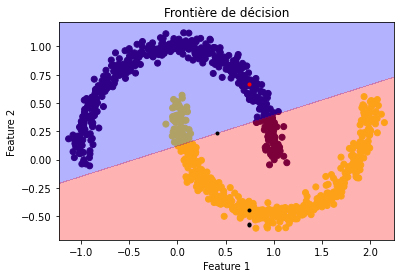

In [15]:
# Convertir les données en tenseurs PyTorch
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)

# Créer un modèle de régression logistique simple
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

input_dim = 2
model = LogisticRegressionModel(input_dim)

# Définir la fonction de perte et l'optimiseur
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Entraîner le modèle
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t.view(-1, 1))

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Époque [{epoch+1}/{num_epochs}], Perte: {loss.item()}')

# Évaluer le modèle sur des données de test
X_test_t = torch.tensor(X_test, dtype=torch.float32)
with torch.no_grad():
    predicted = model(X_test_t)
    predicted_class = (predicted >= 0.5).float()




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.56it/s]

Query instance (original outcome : 0)


,x0,x1,outcome
0,0.744324,0.671533,0



Diverse Counterfactual set (new outcome: 1.0)


,x0,x1,outcome
0,0.167674,0.050620,1
1,0.744324,0.176011,1
2,0.155863,0.097135,1
3,-0.584521,-0.349584,1


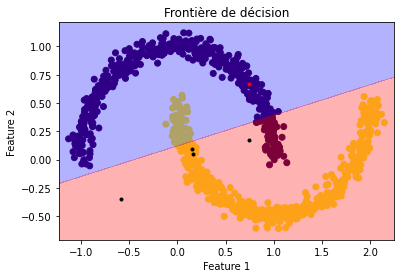

In [16]:
data = dice_ml.Data(dataframe=train_dataset, continuous_features=['x0','x1'], outcome_name='outcome')
m = dice_ml.Model(model=model, backend="PYT")
exp = dice_ml.Dice(data,m)
# Generate counterfactual examples
query_instance = test_dataset[0:1]
dice_exp = exp.generate_counterfactuals(query_instance, total_CFs=4, desired_class="opposite")
# Visualize counterfactual explanation
dice_exp.visualize_as_dataframe()
# Tracer la frontière de décision
plt.scatter(X_train_t[:, 0], X_train_t[:, 1], c=y_train_t)
x_min, x_max = X_train_t[:, 0].min() - 0.1, X_train_t[:, 0].max() + 0.1
y_min, y_max = X_train_t[:, 1].min() - 0.1, X_train_t[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
Z = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32))
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z.detach().numpy(), levels=[0, 0.5, 1], colors=['blue', 'red'], alpha=0.3)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Frontière de décision')
plt.plot(X_test_t[0, 0], X_test_t[0, 1], 'r.')
d = dice_exp.cf_examples_list[0].final_cfs_df.to_numpy()
plt.plot(d[:, 0], d[:, 1], 'k.')
plt.show()

In [17]:
dataset =helpers.load_adult_income_dataset()
target = dataset['income']
train_dataset, test_dataset, _, _ = train_test_split(dataset, target, test_size=0.2, random_state=0,stratify=target)

# initialise DiCE
d = dice_ml.Data(dataframe=train_dataset, continuous_features=['age','hours_per_week'], outcome_name='income') 

m= dice_ml.Model(model_path=dice_ml.utils.helpers.get_adult_income_modelpath(), backend='TF2',func ="ohe-min-max")
exp = dice_ml.Dice(d,m)

In [18]:
# Generate counterfactual examples
query_instance = test_dataset.drop(columns="income")[0:1]
dice_exp = exp.generate_counterfactuals(query_instance, total_CFs=4, desired_class="opposite")
# Visualize counterfactual explanation
dice_exp.visualize_as_dataframe()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:03<00:00,  3.33s/it]

Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,29,Private,HS-grad,Married,Blue-Collar,White,Female,38,0



Diverse Counterfactual set (new outcome: 1.0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,29,Self-Employed,Masters,Married,Blue-Collar,White,Female,38,1
1,29,Private,HS-grad,Married,Professional,White,Female,65.0,1
2,51.0,Private,HS-grad,Married,White-Collar,White,Female,38,1
3,29,Private,Prof-school,Married,Blue-Collar,White,Female,38.0,1


Avec un reseau de neurones sur Pytorch 

In [19]:
# Generate the dataset
X, y = make_moons(n_samples=2000, shuffle=True, noise=0.05)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1000, train_size=1000, shuffle=True)

# Convert data to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)  # Input layer to hidden layer
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)  # Hidden layer to output layer
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Initialize the model
input_dim = X_train.shape[1]
model = SimpleNN(input_dim)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train.view(-1, 1))
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


# Évaluer le modèle sur des données de test
X_test_t = torch.tensor(X_test, dtype=torch.float32)
with torch.no_grad():
    predicted = model(X_test_t)
    predicted_class = (predicted >= 0.5).float()




Epoch [100/5000], Loss: 0.3587
Epoch [200/5000], Loss: 0.2535
Epoch [300/5000], Loss: 0.2083
Epoch [400/5000], Loss: 0.1782
Epoch [500/5000], Loss: 0.1505
Epoch [600/5000], Loss: 0.1242
Epoch [700/5000], Loss: 0.1000
Epoch [800/5000], Loss: 0.0793
Epoch [900/5000], Loss: 0.0626
Epoch [1000/5000], Loss: 0.0497
Epoch [1100/5000], Loss: 0.0396
Epoch [1200/5000], Loss: 0.0312
Epoch [1300/5000], Loss: 0.0251
Epoch [1400/5000], Loss: 0.0206
Epoch [1500/5000], Loss: 0.0171
Epoch [1600/5000], Loss: 0.0144
Epoch [1700/5000], Loss: 0.0122
Epoch [1800/5000], Loss: 0.0105
Epoch [1900/5000], Loss: 0.0091
Epoch [2000/5000], Loss: 0.0079
Epoch [2100/5000], Loss: 0.0069
Epoch [2200/5000], Loss: 0.0061
Epoch [2300/5000], Loss: 0.0054
Epoch [2400/5000], Loss: 0.0049
Epoch [2500/5000], Loss: 0.0043
Epoch [2600/5000], Loss: 0.0039
Epoch [2700/5000], Loss: 0.0035
Epoch [2800/5000], Loss: 0.0032
Epoch [2900/5000], Loss: 0.0029
Epoch [3000/5000], Loss: 0.0026
Epoch [3100/5000], Loss: 0.0024
Epoch [3200/5000]

/tmp/ipykernel_47474/3140061492.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_t = torch.tensor(X_test, dtype=torch.float32)


In [20]:
datset = np.hstack((X_train, y_train.reshape(-1,1)))
train_dataset = pd.DataFrame(datset, columns= ["x0", "x1","outcome"])
test_dataset = pd.DataFrame(X_test, columns= ["x0", "x1"])


data = dice_ml.Data(dataframe=train_dataset, continuous_features=['x0','x1'], outcome_name='outcome')
m = dice_ml.Model(model=model, backend="PYT")
exp = dice_ml.Dice(data,m)
# Generate counterfactual examples
query_instance = test_dataset[0:1]
dice_exp = exp.generate_counterfactuals(query_instance, total_CFs=4, desired_class="opposite")
# Visualize counterfactual explanation
dice_exp.visualize_as_dataframe()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.02it/s]

Query instance (original outcome : 0)


,x0,x1,outcome
0,0.028512,0.975784,0



Diverse Counterfactual set (new outcome: 1.0)


,x0,x1,outcome
0,-0.140709,-0.472860,1
1,1.392029,0.061862,1
2,0.028512,0.503023,1
3,0.028512,0.494884,1


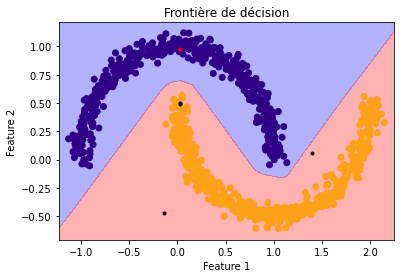

In [21]:
# Tracer la frontière de décision
plt.scatter(X_train_t[:, 0], X_train_t[:, 1], c=y_train_t)
x_min, x_max = X_train_t[:, 0].min() - 0.1, X_train_t[:, 0].max() + 0.1
y_min, y_max = X_train_t[:, 1].min() - 0.1, X_train_t[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
Z = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32))
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z.detach().numpy(), levels=[0, 0.5, 1], colors=['blue', 'red'], alpha=0.3)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Frontière de décision')
plt.plot(X_test_t[0, 0], X_test_t[0, 1], 'r.')
d = dice_exp.cf_examples_list[0].final_cfs_df.to_numpy()
plt.plot(d[:, 0], d[:, 1], 'k.')
plt.show()